In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, callbacks, optimizers, applications

## Data Preperation

In [2]:
(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_valid = x_valid.astype('float32') / 255.0

n_classes = 10
input_shape = (32, 32, 3)

170508288/170498071 [==============================] - 6s 0us/step


## Callbacks

In [3]:
import os
class LearningCurve(callbacks.Callback):
    def __init__(self, metrics_to_plot, directory):
        self.metrics_to_plot = metrics_to_plot
        self.directory = directory
        if not os.path.exists(directory):
            os.mkdir(directory)


    def on_train_begin(self, logs):
        self.metric_logs = []
  
    def on_epoch_end(self, epoch, logs):
        self.metric_logs.append(logs)

    def on_train_end(self, logs):
        metrics_df = pd.DataFrame(self.metric_logs)
        for metric in self.metrics_to_plot:
            fig, ax = plt.subplots(figsize=(20, 6))
            fig.suptitle(metric.title(), fontsize=18)
            metrics_df[[metric, f'val_{metric}']].plot(style='o-', ax=ax)
            plt.savefig(os.path.join(self.directory, metric))
            plt.show()

        self.metric_logs = []
        
get_callbacks = lambda x: [
    LearningCurve(['loss', 'accuracy'], x), 
    callbacks.ReduceLROnPlateau(patience=5, verbose=1), 
    callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
]

## Model

2022-12-15 03:25:12.689705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 03:25:12.857008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 03:25:12.858309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 03:25:12.860143: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
classification_head (Dense)  (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________


2022-12-15 03:25:19.690490: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-15 03:25:24.341671: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


196/196 [==============================] - 19s 42ms/step - loss: 1.9539 - accuracy: 0.3455 - val_loss: 2.2876 - val_accuracy: 0.1420
Epoch 2/100
196/196 [==============================] - 7s 34ms/step - loss: 1.3505 - accuracy: 0.5317 - val_loss: 2.6885 - val_accuracy: 0.1578
Epoch 3/100
196/196 [==============================] - 7s 35ms/step - loss: 1.1198 - accuracy: 0.6076 - val_loss: 2.4748 - val_accuracy: 0.1788
Epoch 4/100
196/196 [==============================] - 7s 35ms/step - loss: 0.9641 - accuracy: 0.6607 - val_loss: 2.4065 - val_accuracy: 0.2239
Epoch 5/100
196/196 [==============================] - 7s 35ms/step - loss: 0.8480 - accuracy: 0.7008 - val_loss: 2.2740 - val_accuracy: 0.2302
Epoch 6/100
196/196 [==============================] - 7s 35ms/step - loss: 0.7438 - accuracy: 0.7375 - val_loss: 1.9959 - val_accuracy: 0.2818
Epoch 7/100
196/196 [==============================] - 7s 35ms/step - loss: 0.6482 - accuracy: 0.7698 - val_loss: 1.9769 - val_accuracy: 0.2895
Epo

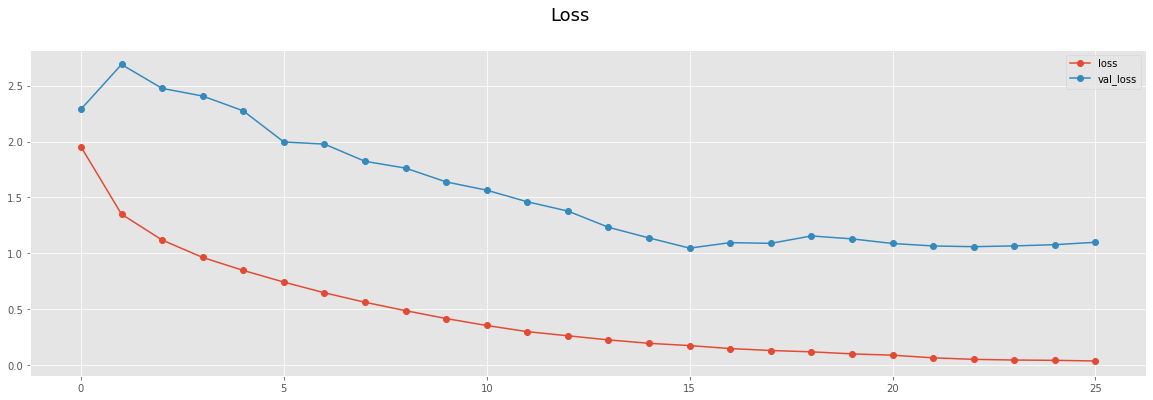

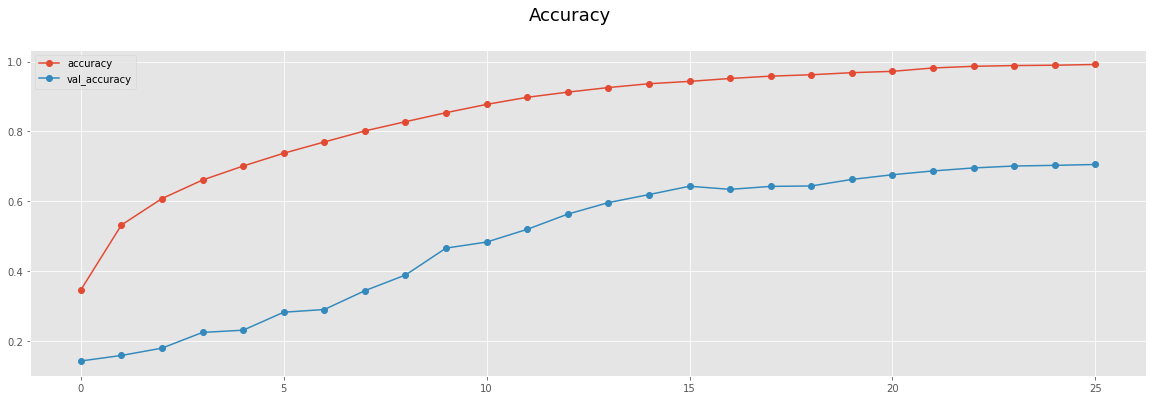

Epoch 00026: early stopping


In [4]:
tf.keras.backend.clear_session()

backbone = applications.MobileNetV2(input_shape=input_shape, include_top=False)

inputs = layers.Input(shape=input_shape, name='input')
features = backbone(inputs)
features = layers.GlobalAvgPool2D()(features)
outputs = layers.Dense(n_classes, activation='softmax', name='classification_head')(features)

model = models.Model(inputs, outputs)
model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=256, epochs=100, callbacks=get_callbacks('model'))

## Bagging

In [5]:
class BaggingHead(models.Model):
    def __init__(self, n_units, activation, size, rate, **kwargs):
        super().__init__(**kwargs)
        self.dense = layers.Dense(n_units)
        self.dropouts = [layers.Dropout(rate) for _ in range(size)]
        self.average = layers.Average()
        self.activation = layers.Activation(activation)
        
        
    def call(self, inputs):
        outputs = [self.dense(dropout(inputs)) for dropout in self.dropouts]
        averaged = self.average(outputs)
        activated = self.activation(averaged)
        return activated
        

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1, 1, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
bagging_classification_head  (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/100
196/196 [==============================] - 12s 41ms/step - loss: 1.9584 - accuracy: 0.3520 - val_loss: 2.5112 - val_accuracy: 0.1184
Epoch 2/100
196/196 [==============================] - 7s 36ms/step - loss: 1.3119 - accuracy: 0.54

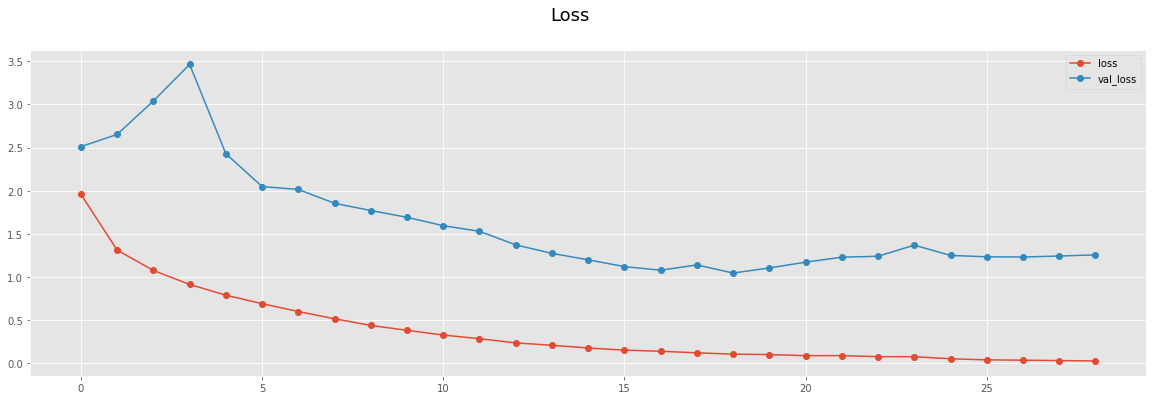

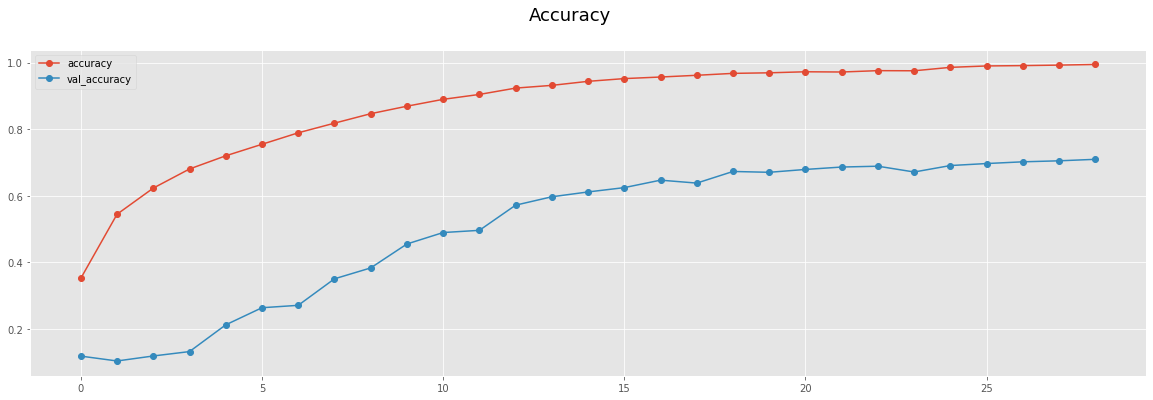

Epoch 00029: early stopping


In [6]:
tf.keras.backend.clear_session()

backbone = applications.MobileNetV2(input_shape=input_shape, include_top=False)

inputs = layers.Input(shape=input_shape, name='input')
features = backbone(inputs)
features = layers.GlobalAvgPool2D()(features)
outputs = BaggingHead(n_classes, activation='softmax', size=5, rate=0.2, name='bagging_classification_head')(features)

model = models.Model(inputs, outputs)
model.summary()

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=256, epochs=100, callbacks=get_callbacks('model'))